In [51]:
import pandas as pd
import re
import os
import shutil
import glob
from collections import Counter
from thefuzz import fuzz
from thefuzz import process
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['font.family'] = 'Roboto'
matplotlib.rcParams['figure.dpi'] = 300

def check_scale_pattern(string):
    pattern_a = r"scale of assessments for the financial period \d{4}-\d{4}"
    pattern_b = r"scale of assessment for the financial period \d{4}-\d{4}"
    pattern_c = r"scale of assessment for \d{4}"
    pattern_d = r"scale of assessments for \d{4}"
    pattern_e = r"scale of assessments \d{4}-\d{4}"
    pattern_f = r"scale of assessment, \d{4} and future years"
    pattern_g = r"(scale of assessments\b|scales of assessment)"

    patterns = [pattern_a, pattern_b, pattern_c, pattern_d, pattern_e, pattern_g]

    for pattern in patterns:
        if re.match(pattern, string) and not ":" in string:
            return True

    return False

def get_session_and_resolution_number(string):
    pattern = r"\d+"

    match = re.findall(pattern, string)
    if match:
        integer_part = int(match[0])
        if len(match)>1:
            fractional_part = int(match[1])
        else:
            fractional_part = 0
        return integer_part, fractional_part

    return None

def check_dots(string):
    pattern = r"[ .]*"

    if re.fullmatch(pattern, string):
        return True

    return False

def remove_brackets(string):
    pattern = r"\s*\(.*?\)"

    cleaned_string = re.sub(pattern, "", string)
    return cleaned_string.strip()


In [22]:
df = pd.read_csv("data/wha_resolutions.csv")

In [23]:
all_years = range(1948, 2023)

found_resolutions = []
other_resolutions = []
found_years = []
current_year = 1948
current_resolutions = []
current_resolution_titles = []
for i in range(len(df)):
    df.loc[i, "title"] = re.sub("\ufeff", "", df.loc[i, "title"])
    df.loc[i, "title"] = re.sub("\n", "", df.loc[i, "title"])
    session, resolution_number = get_session_and_resolution_number(df.loc[i, 'number'])
    year = 1947 + session
    if year!=current_year:
        if len(current_resolutions)>0 and current_year not in found_years:
            print(current_resolutions)
            print(current_resolution_titles)
        current_year = year
        current_resolutions = []
        current_resolution_titles = []
    if "assessment" in df.loc[i, "title"].lower():
        current_resolutions.append(df.loc[i, 'number'])
        current_resolution_titles.append(df.loc[i, 'title'])
    if "scale of assessment" in df.loc[i, "title"].lower() or "scales of assessment" in df.loc[i, "title"].lower():
        # print(f"{df.loc[i, 'number']}: {df.loc[i, 'title']}")
        if check_scale_pattern(df.loc[i, 'title'].lower()):
            found_resolutions.append(f"{df.loc[i, 'number']}: {df.loc[i, 'title']}")
            found_years.append(year)
        else:
            other_resolutions.append(f"{df.loc[i, 'number']}: {df.loc[i, 'title']}")

print("Found resolutions\n------------\n")
for i in range(len(found_resolutions)):
    res_n = found_resolutions[i].split(':')[0]
    session, resolution_number = get_session_and_resolution_number(res_n)
    year = 1947 + session
    if not os.path.exists(f"data/scale_of_assessments/{res_n}.pdf"):
        try:
            shutil.copy2(f"data/IRIS_documents/{year}/{res_n}.pdf", f"data/scale_of_assessments/{res_n}.pdf")
        except:
            shutil.copy2(f"data/IRIS_documents/{year}/{res_n.split('.')[0]}.resolutions.pdf", f"data/scale_of_assessments/{res_n.split('.')[0]}.resolutions.pdf")
    print(found_resolutions[i])

print(set(all_years)-set(found_years))

print("\nOther resolutions\n------------\n")
for i in range(len(other_resolutions)):
    print(other_resolutions[i])

['WHA2.57', 'WHA2.69', 'WHA2.68', 'WHA2.70', 'WHA2.67']
['Establishment of the working capital fund as a single fund and assessment of new members', 'Scale of assessments: contribution of the state of South Korea to the budgets of 1949 and 1950', 'Scale of assessments: determination of the maximum contribution to the regular expenses of the Organization', 'Scale of assessments: financial obligations of associate members', 'Scale of assessments: contribution of Israel to the budgets of 1949 and 1950']
['WHA33.9', 'WHA33.12', 'WHA33.13', 'WHA33.11', 'WHA33.10', 'WHA33.14']
['Assessment of new members and associate members: assessment of the Seychelles', 'Assessment of new members and associate members: unpaid contributions of Southern Rhodesia', 'Assessment of new members and associate members: assessment of Zimbabwe', 'Assessment of new members and associate members: assessment of San Marino', 'Assessment of new members and associate members: assessment of Equatorial Guinea', 'Amendment

In [24]:
files = glob.glob("data/scale_of_assessments_manual/WHA*.tsv")
files.sort()

find_str = ["Byelorussian Soviet Socialist Republic", "Ukrainian Soviet Socialist Republic", "Ukrainian Soviet Socialist Republics", "Azerbaiian", "Cabo Verde", "Cameroun", "Fiii", "Fili", "Fill", "Guy ana", "Tran", "Malavsia", "Domínica", "Ceylon", "Viet Nam", "Viet-Nam", "Oatar", "Federal Republic of Germany", "Federated States of Micronesia"]
replace_str = ["Byelorussian SSR", "Ukrainian SSR", "Ukrainian SSR", "Azerbaijan", "Cape Verde", "Cameroon", "Fiji", "Fiji", "Fiji", "Guyana", "Iran", "Malaysia", "Dominica", "Sri Lanka", "Vietnam", "Vietnam", "Qatar", "Germany", "Micronesia"]

country_names = []
for file in files:
    print(file)
    df = pd.read_csv(file, index_col=False, sep="\t", header=None)
    for i in range(len(df)):
        df.loc[i, 0] = re.sub("\.", "", df.loc[i, 0])
        df.loc[i, 0] = re.sub("•", "", df.loc[i, 0])
        df.loc[i, 0] = re.sub("\*", "", df.loc[i, 0])
        df.loc[i, 0] = re.sub("\?", "", df.loc[i, 0])
        df.loc[i, 0] = df.loc[i, 0].strip()
        df.loc[i, 0] = remove_brackets(df.loc[i, 0])
        if "," in df.loc[i, 0]:
            df.loc[i, 0] = df.loc[i, 0].split(",")[1].strip()+" "+df.loc[i, 0].split(",")[0].strip()
        for j in range(len(find_str)):
            if df.loc[i, 0]==find_str[j]:
                df.loc[i, 0] = replace_str[j]
                
        country_names.append(df.loc[i, 0])

good_country_names = list(np.array(list(dict(Counter(country_names)).keys()))[np.array(list(dict(Counter(country_names)).values()))>=3])

df_merged = pd.DataFrame()
for file in files:
    print(file)
    df = pd.read_csv(file, index_col=False, sep="\t", header=None)
    for i in range(len(df)):
        df.loc[i, 0] = re.sub("\.", "", df.loc[i, 0])
        df.loc[i, 0] = re.sub("•", "", df.loc[i, 0])
        df.loc[i, 0] = re.sub("\*", "", df.loc[i, 0])
        df.loc[i, 0] = re.sub("\?", "", df.loc[i, 0])
        df.loc[i, 0] = df.loc[i, 0].strip()
        df.loc[i, 0] = remove_brackets(df.loc[i, 0])
        if "," in df.loc[i, 0]:
            df.loc[i, 0] = df.loc[i, 0].split(",")[1].strip()+" "+df.loc[i, 0].split(",")[0].strip()
            
        for j in range(len(find_str)):
            if df.loc[i, 0]==find_str[j]:
                df.loc[i, 0] = replace_str[j]
                
        matches = process.extract(df.loc[i, 0], good_country_names, scorer=fuzz.partial_ratio)
        if matches[0][1]==100:
            continue
        print(f"{df.loc[i, 0]}: {matches}")

    df.rename(columns={0: "Country", 1: file.split("/")[-1].split(".")[0]}, inplace=True)
    
    if len(df_merged)==0:
        df_merged = df
        df_merged.set_index("Country", inplace=True)
    else:
        df.set_index("Country", inplace=True)
        df_merged = df_merged.join(df, how="outer")

df_merged.to_csv("data/contributions.csv")

scale_of_assessments_manual/WHA15.tsv
scale_of_assessments_manual/WHA25.tsv
scale_of_assessments_manual/WHA34.tsv
scale_of_assessments_manual/WHA44.tsv
scale_of_assessments_manual/WHA56.tsv
scale_of_assessments_manual/WHA64.tsv
scale_of_assessments_manual/WHA75.tsv
scale_of_assessments_manual/WHA15.tsv
Dahomey: [('Kenya', 50), ('Oman', 50), ('Singapore', 46), ('Suriname', 46), ('Cameroon', 43)]
Federation of Rhodesia and Nyasaland: [('Poland', 67), ('Swaziland', 67), ('Thailand', 62), ('Congo', 60), ('Gabon', 60)]
Laos: [('Barbados', 75), ('Malaysia', 75), ("Lao People's Democratic Republic", 75), ('Venezuela', 67), ('Honduras', 57)]
Federation of Malaya: [('Malaysia', 86), ('Malta', 80), ('Mali', 75), ('Malawi', 67), ('Congo', 60)]
Ruanda-Urundi: [('Burundi', 86), ('Rwanda', 83), ('Uganda', 83), ('Nauru', 80), ('Iran', 75)]
Tanganyika: [('Tonga', 80), ('United Republic of Tanzania', 78), ('Angola', 67), ('Afghanistan', 60), ('Gabon', 60)]
United Arab Republic: [('Syrian Arab Republic'

In [25]:
df_merged_persistent = df_merged.dropna()
df_merged_persistent
df_merged

,WHA15,WHA25,WHA34,WHA44,WHA56,WHA64,WHA75
Country,,,,,,,
Afghanistan,0.05,0.04,0.01,0.01,0.0089,0.004,0.006
Albania,0.04,0.04,0.01,0.01,0.0030,0.010,0.008
Algeria,NaN,0.08,0.12,0.15,0.0689,0.128,0.109
Andorra,NaN,NaN,NaN,NaN,0.0039,0.007,0.005
Angola,NaN,NaN,0.01,0.01,0.0020,0.010,0.010
...,...,...,...,...,...,...,...
Yemen,0.04,0.04,0.01,0.01,0.0059,0.010,0.008
Yugoslavia,0.35,0.34,0.41,0.45,NaN,NaN,NaN
Zaire,NaN,0.04,0.02,0.01,NaN,NaN,NaN


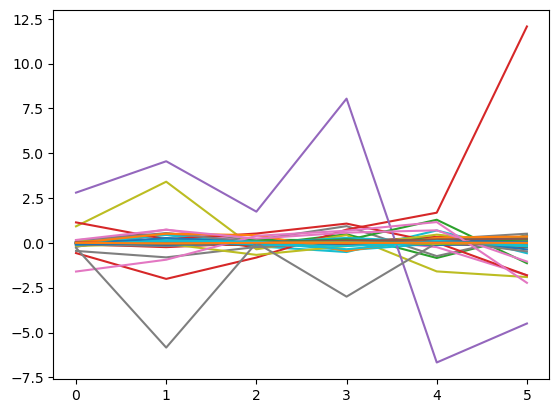

In [26]:
df_change = df_merged.copy()
for i in range(len(df_change)):
    for j in range(1, len(df_change.iloc[0,:])):
        if np.isnan(df_merged.iloc[i, j-1]):
            df_change.iloc[i, j] = df_merged.iloc[i, j]
        else:
            df_change.iloc[i, j] = df_merged.iloc[i, j] - df_merged.iloc[i, j-1]

df_change = df_change.dropna()

fig, ax = plt.subplots()
for i in range(len(df_change)):
    Y = df_change.iloc[i, :].to_list()
    if Y[0]==0:
        continue
    # Y = [100*y/Y[0] for y in Y][1:]
    Y = Y[1:]
    ax.plot(Y)


In [38]:
df_log = np.log10(df_merged_persistent)

df_log_change = df_log.copy()
for i in range(len(df_log_change)):
    for j in range(1, len(df_log_change.iloc[0,:])):
        if np.isnan(df_log.iloc[i, j-1]):
            df_log_change.iloc[i, j] = df_log.iloc[i, j]
        else:
            df_log_change.iloc[i, j] = df_log.iloc[i, j] - df_log.iloc[i, j-1]

df_log_change = df_log_change.dropna()
df_log_change.drop(['WHA15'], axis=1, inplace=True)
df_log_change

,WHA25,WHA34,WHA44,WHA56,WHA64,WHA75
Country,,,,,,
Afghanistan,-0.096910,-0.602060,0.000000,-0.050610,-0.347330,0.176091
Albania,0.000000,-0.602060,0.000000,-0.522879,0.522879,-0.096910
Argentina,-0.077297,0.000000,-0.073577,0.240357,-0.595389,0.398847
Australia,-0.061270,0.134699,-0.067752,0.016843,0.081890,0.038254
Austria,0.086186,0.146128,0.012234,0.111990,-0.039342,-0.098111
...,...,...,...,...,...,...
United States of America,-0.003925,-0.091174,0.000000,-0.055517,0.000000,0.000000
Uruguay,-0.221849,-0.176091,0.000000,0.293915,-0.464611,0.532424
Venezuela,-0.103896,0.121994,0.057992,-0.437070,0.185812,-0.253892


[Text(0.5, 0, '1962'),
 Text(1.5, 0, '1972'),
 Text(2.5, 0, '1982'),
 Text(3.5, 0, '1992'),
 Text(4.5, 0, '2002'),
 Text(5.5, 0, '2012'),
 Text(6.5, 0, '2022')]

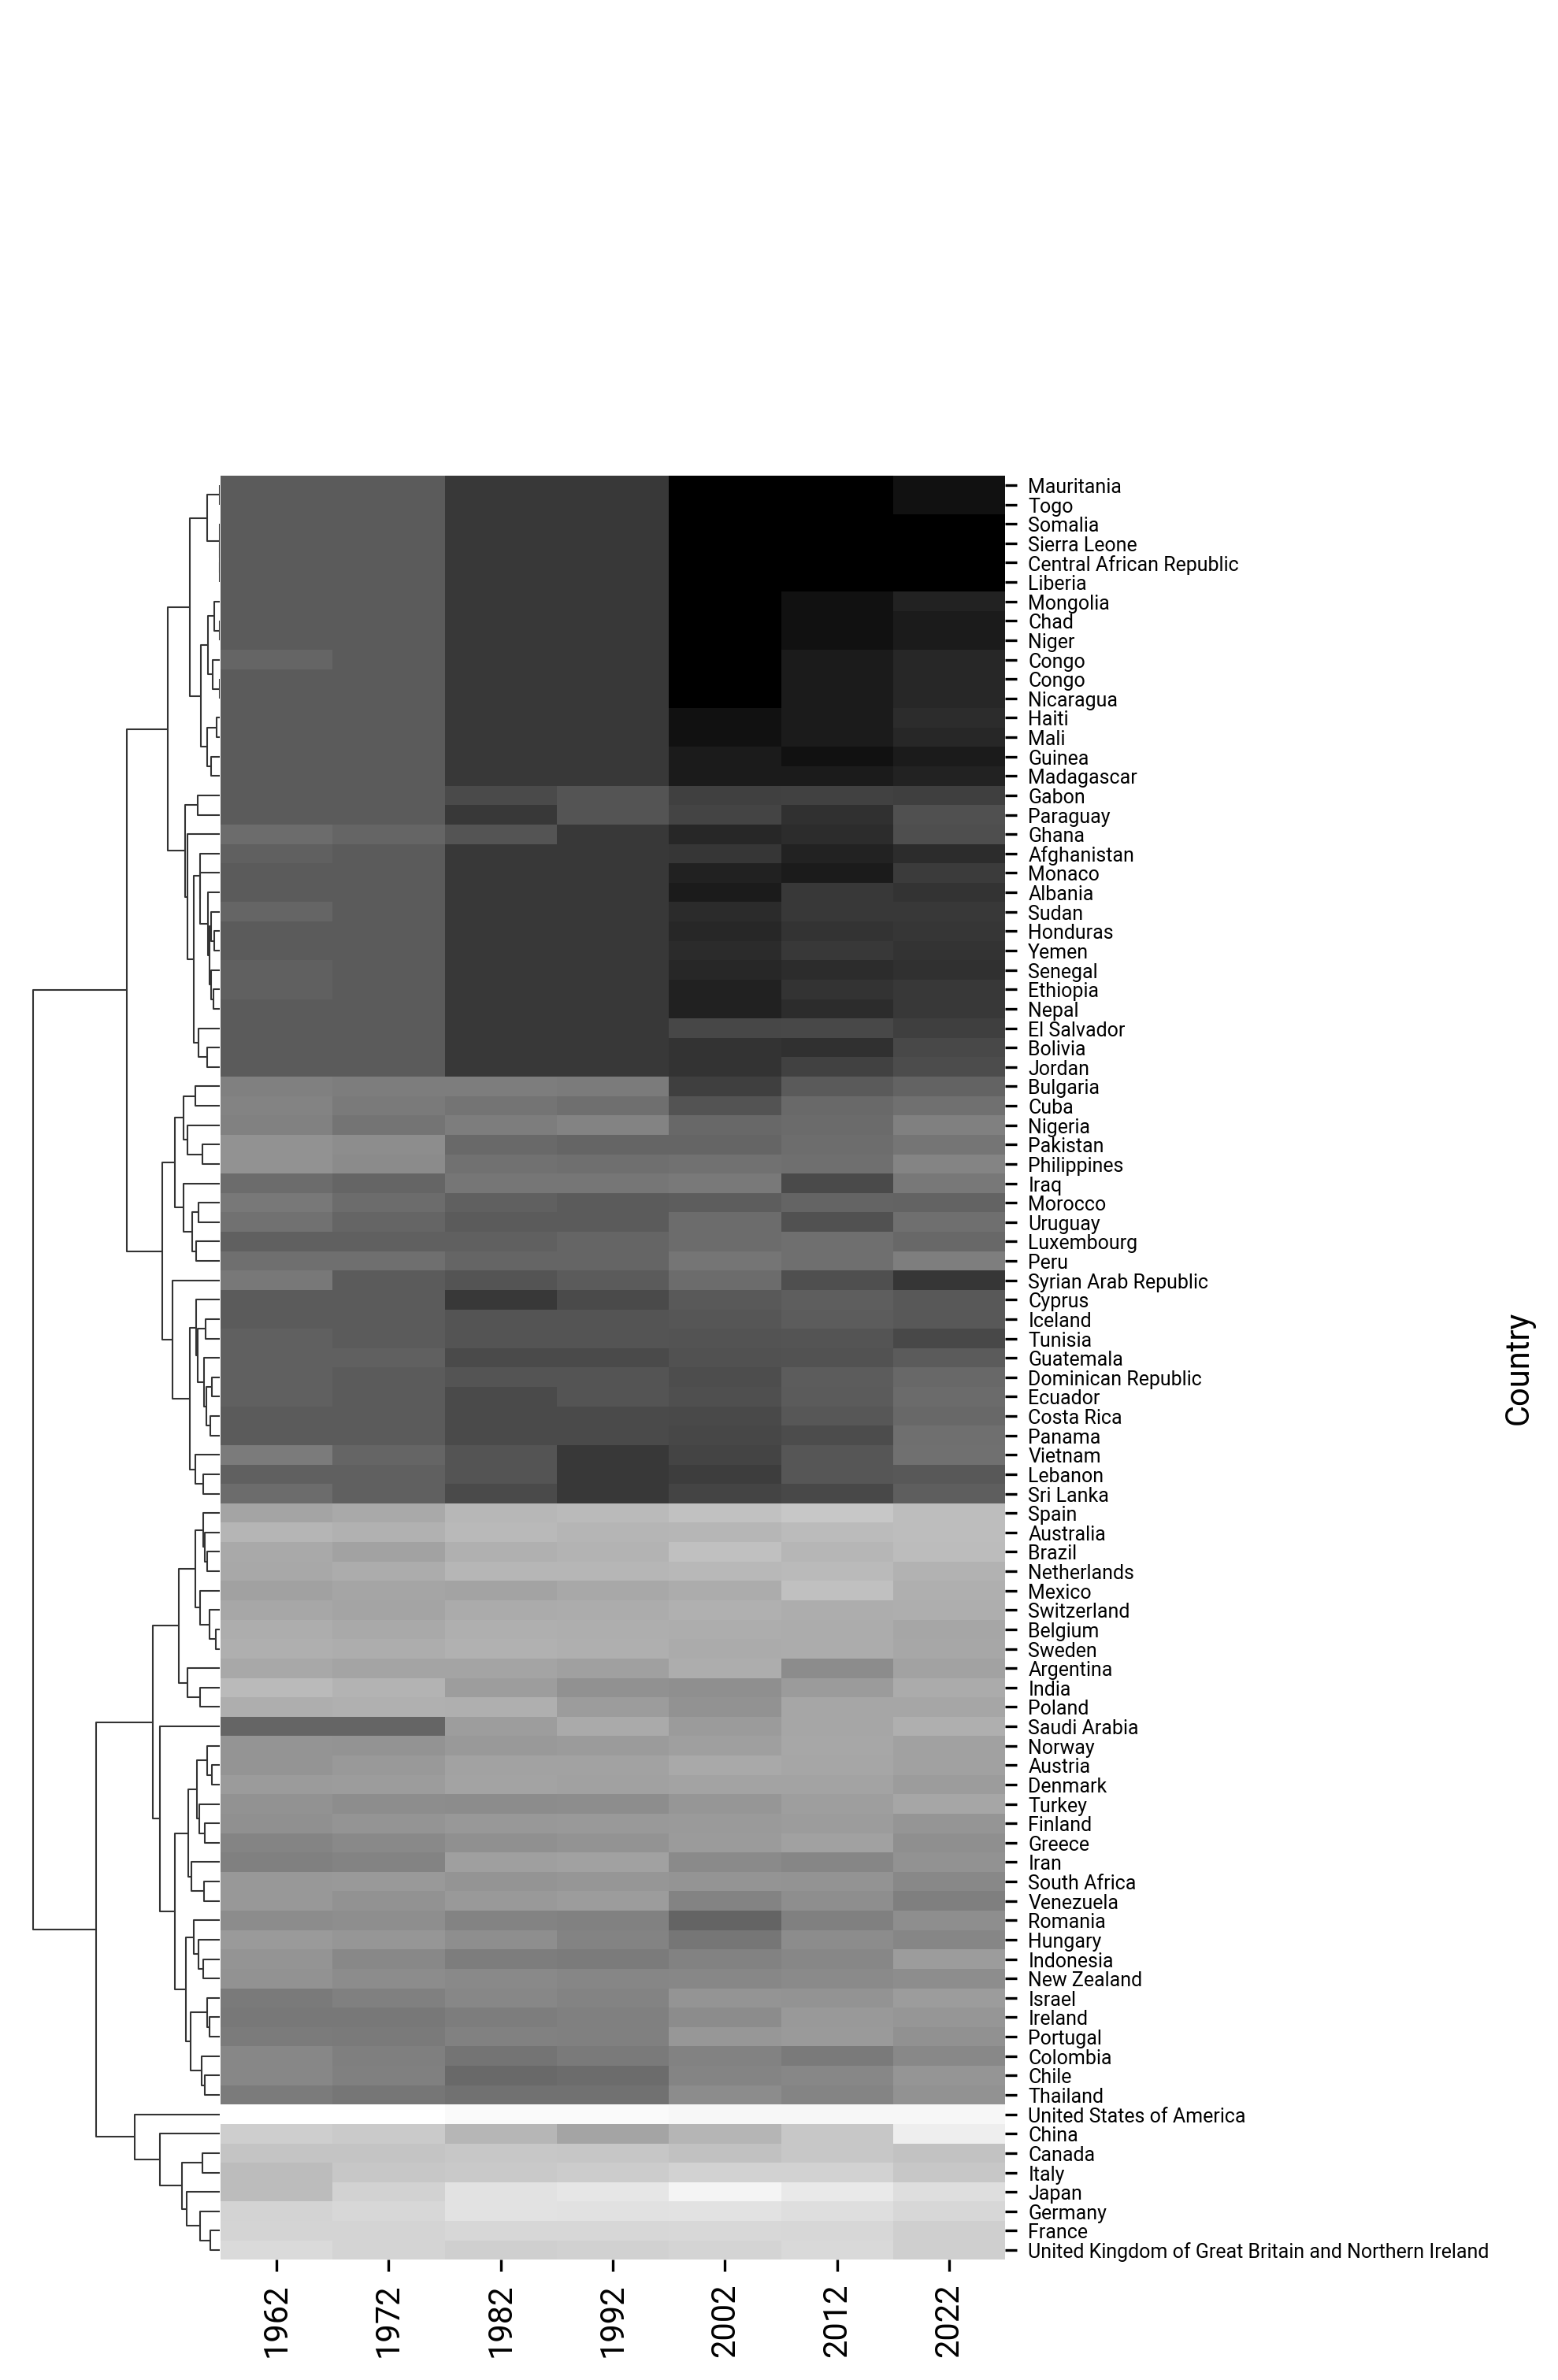

In [55]:
cg = sns.clustermap(df_log, figsize=(8,10), col_cluster=False, cbar_pos=None, cmap='gray', yticklabels=1)
# cg.ax_row_dendrogram.set_visible(False)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)  # ytick rotate
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
cg.ax_heatmap.set_xticklabels([1962, 1972, 1982, 1992, 2002, 2012, 2022])